# Examples for running FLORIS

In [1]:
# load modules
from floris.floris import Floris
import numpy as np

## Setup floris and process input file

In [2]:
floris = Floris("floris.json")

## Calculate Wake

In [3]:
import time

t1 = time.time()

floris.farm.flow_field.calculate_wake()

t2 = time.time()

print('Time to compute wake = ', t2-t1, 's')

Time to compute wake =  0.4920492172241211 s


## Compute Velocities at each Turbine

In [4]:
for coord, turbine in floris.farm.turbine_map.items():
    print(str(coord) + ":")
    print("\tCp -", turbine.Cp)
    print("\tCt -", turbine.Ct)
    print("\tpower -", turbine.power)
    print("\tai -", turbine.aI)
    print("\taverage velocity -", turbine.get_average_velocity())

(0.0, 0.0):
	Cp - 0.4632855723662577
	Ct - 0.7660588467878915
	power - 1722536.18711
	ai - 0.258162682154
	average velocity - 7.86672867207
(800.0, 0.0):
	Cp - 0.4523935246868955
	Ct - 0.8386365324111994
	power - 710523.806696
	ai - 0.299149640535
	average velocity - 5.90257793124
(0.0, 600.0):
	Cp - 0.4632855723662577
	Ct - 0.7660588467878915
	power - 1722536.18711
	ai - 0.258162682154
	average velocity - 7.86672867207
(800.0, 600.0):
	Cp - 0.4523935246868955
	Ct - 0.8386365324111994
	power - 710523.806696
	ai - 0.299149640535
	average velocity - 5.90257793124


## Plot the Flow Field (z-plane)

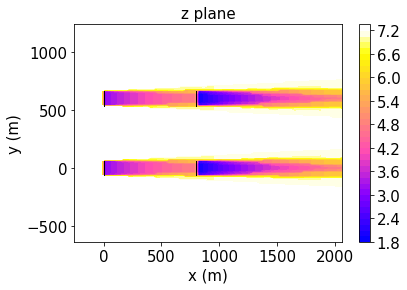

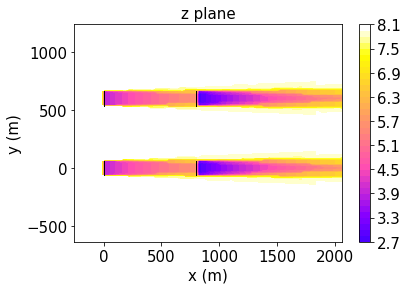

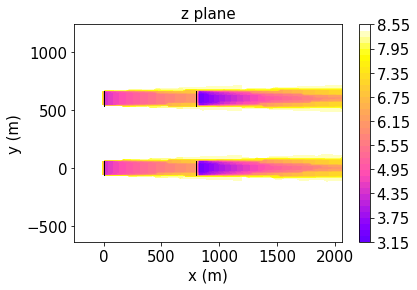

In [5]:
# this plots the streamwise velocity at:

# inputs -> percent of z domain entered as a list

#     1.  20% of the z height domain (the z height domain is 2x hub height, i.e. 36m)
#     2.  50% of the z height domain (at hub height)
#     3.  80% of the z height domain (144m)

floris.farm.flow_field.plot_z_planes([0.2, 0.5, 0.8])

## Plot the Flow Field (x-plane)

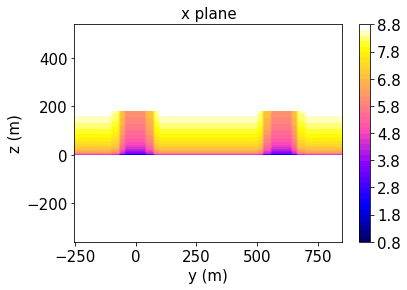

In [6]:
# plot a cut-through of the flow field at a particular x distance downstream.

# inputs -> percent of x domain entered as a list 

floris.farm.flow_field.plot_x_planes([0.4])

## Optimize Wind Farm using Wake Steering 

In [7]:
import OptModules  # modules used for optimizing FLORIS
import numpy as np

turbines      = [turbine for _, turbine in floris.farm.flow_field.turbine_map.items()]
power_initial = np.sum([turbine.power for turbine in turbines])  # determine initial power production

# set bounds for the optimization on the yaw angles (deg)
minimum_yaw_angle = 0.0
maximum_yaw_angle = 25.0

# compute the optimal yaw angles
opt_yaw_angles = OptModules.wake_steering(floris,minimum_yaw_angle,maximum_yaw_angle)

print('Optimal yaw angles for:')
for i,yaw in enumerate(opt_yaw_angles):
    print('Turbine ', i, ' yaw angle = ', np.degrees(yaw))

Optimizing wake redirection control...
Number of parameters to optimize =  4
Optimal yaw angles for:
Turbine  0  yaw angle =  20.9988395187
Turbine  1  yaw angle =  4.15418504227
Turbine  2  yaw angle =  20.9988395152
Turbine  3  yaw angle =  4.15418503965


## Assign New Yaw Angles 

In [8]:
# assign yaw angles to turbines
turbines    = [turbine for _, turbine in floris.farm.flow_field.turbine_map.items()]
for i,turbine in enumerate(turbines):
    turbine.yaw_angle = opt_yaw_angles[i]

## Plot Optimized Flow Field 

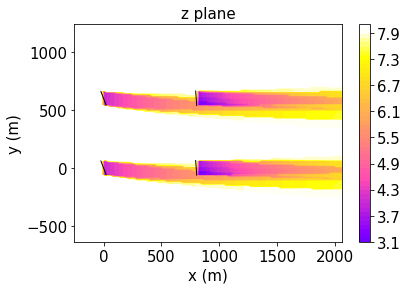

Power increased by  8.93633391051 %


In [9]:
# compute the new wake with yaw angles
floris.farm.flow_field.calculate_wake()

# optimal power 
power_opt = np.sum([turbine.power for turbine in turbines]) 

# plot results
floris.farm.flow_field.plot_z_planes([0.5])

print('Power increased by ', 100*(power_opt-power_initial)/power_initial, '%')
